AiApp Miniproject; Leonie Däullary, Ruwen Frick

Needed packages

In [173]:
pip install opendatasets tensorflow matplotlib scipy numpy tabulate

Note: you may need to restart the kernel to use updated packages.


Imports

In [174]:
import tensorflow as tf

from keras_preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from keras.layers import Flatten, Dense, MaxPooling2D

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import opendatasets as od
import os
from pathlib import Path

from numpy import argmax
from tabulate import tabulate
from sklearn.metrics import accuracy_score

Dowloading the data

The dataset is hosted on Kaggle. When executing the following cell you will be asked for your Kaggle credentials. These can be acquired by following below steps:

1. Sign in to https://kaggle.com/ or register a new account, then click on your profile picture on the top right and select "My Account" from the menu.

2. Scroll down to the "API" section and click "Create New API Token". This will download a file kaggle.json with the following contents:
    {"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}

In [172]:
dataset_url = "https://www.kaggle.com/pranavraikokte/covid19-image-dataset"
od.download(dataset_url)

path = Path(".", "covid19-image-dataset", "Covid19-dataset").absolute()
print(f"Data stored at: {path}")

train_path = Path(path, "train")
test_path = Path(path, "test")

classes = [dir for dir in sorted(os.listdir(train_path))]


Skipping, found downloaded files in ".\covid19-image-dataset" (use force=True to force download)
Data stored at: c:\Users\ruwen\OneDrive\Dokumente\HSR\_Coding Projekte\_VSCode\covid-detection\code\covid19-image-dataset\Covid19-dataset
['Covid', 'Normal', 'Viral Pneumonia']


Print some examples of the train set

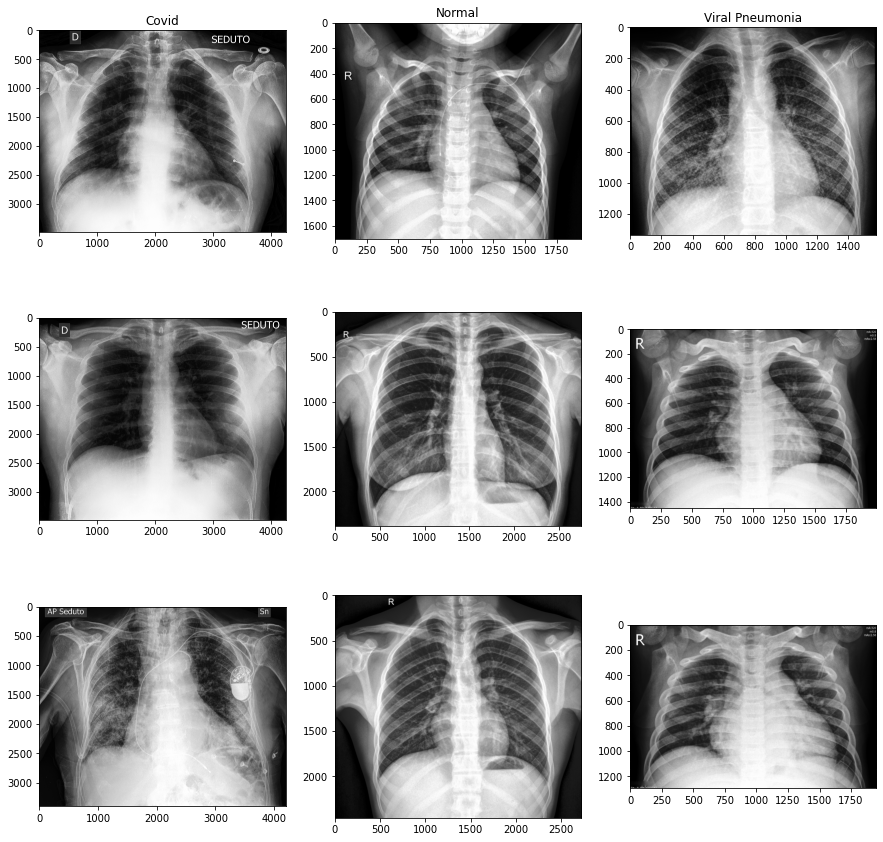

In [158]:
covid_imgs = []
normal_imgs = []
pneumonia_imgs = []

for i in range(1, 4):
    covid_imgs.append(mpimg.imread(pathl.Path(train_path, classes[0], '0' + str(i) + '.jpeg')))
    normal_imgs.append(mpimg.imread(pathl.Path(train_path, classes[1], '0' + str(i) + '.jpeg'))) 
    pneumonia_imgs.append(mpimg.imread(pathl.Path(train_path, classes[2], '0' + str(i) + '.jpeg')))

plt.figure(figsize = (15, 15))

# First row
plt.subplot(3, 3, 1)
plt.imshow(covid_imgs[0])
plt.title('Covid')
plt.subplot(3, 3, 2)
plt.imshow(normal_imgs[0])
plt.title('Normal')
plt.subplot(3, 3, 3)
plt.imshow(pneumonia_imgs[0])
plt.title('Viral Pneumonia')

# Second row
plt.subplot(3, 3, 4)
plt.imshow(covid_imgs[1])
plt.subplot(3, 3, 5)
plt.imshow(normal_imgs[1])
plt.subplot(3, 3, 6)
plt.imshow(pneumonia_imgs[1])

# Third row
plt.subplot(3, 3, 7)
plt.imshow(covid_imgs[2])
plt.subplot(3, 3, 8)
plt.imshow(normal_imgs[2])
plt.subplot(3, 3, 9)
plt.imshow(pneumonia_imgs[2])

plt.show()

Preprocessing and Data Augmentation

In [159]:
# Data generation parameters
rescale = 1. / 255
target_size = (255, 255)
horizontal_flip = True
zoom_range = 0.05
rotation_range = 25
shear_range = 0.2
batch_size  = 64
validation_split = 0.1

train_valid_data_generator = ImageDataGenerator(
    rescale = rescale,
    horizontal_flip = horizontal_flip,
    zoom_range = zoom_range,
    rotation_range = rotation_range,
    shear_range = shear_range,
    validation_split = validation_split
)

test_data_generator = ImageDataGenerator(
    rescale = rescale
)

train_data = train_valid_data_generator.flow_from_directory(
    train_path,
    target_size = target_size,
    classes = classes,
    batch_size  = batch_size,
    subset = 'training'
)

valid_data = train_valid_data_generator.flow_from_directory(
    train_path,
    target_size = target_size,
    classes = classes,
    batch_size  = batch_size,
    subset = 'validation'
)

test_data = test_data_generator.flow_from_directory(
    test_path,
    target_size = target_size,
    classes = classes,
    batch_size  = batch_size,
)

Found 226 images belonging to 3 classes.
Found 25 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


Building the model

In [160]:
# Parameters for first set of layers
num_filters_1 = 32
kernel_size_1 = (2,2)
pool_size_1 = (2, 2)
activation_1 = 'relu'

# Parameters for second set of layers
num_filters_2 = 64
kernel_size_2 = 3
pool_size_2 = (2, 2)
activation_2 = 'relu'

# Parameters for third set of layers
num_filters_3 = 64
kernel_size_3 = 3
pool_size_3 = (2, 2)
activation_3 = 'relu'

model = tf.keras.Sequential([
  Conv2D(num_filters_1, kernel_size_1, activation = activation_1, input_shape = (255, 255, 3)),
  MaxPooling2D(pool_size = pool_size_1),
  Conv2D(num_filters_2, kernel_size_2, activation = activation_2),
  MaxPooling2D(pool_size = pool_size_2),
  Conv2D(num_filters_3, kernel_size_3, activation = activation_3),
  MaxPooling2D(pool_size = pool_size_3),
  Flatten(),
  Dense(64, activation='relu'),
  Dense(len(classes), activation='softmax'),
])

model.summary()


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 254, 254, 32)      416       
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 30, 30, 64)     

Compile and fit model

In [161]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


In [167]:
history = model.fit(
    train_data,
    epochs = 5,
    validation_data = valid_data,
)

Epoch 1/5
4/4 [==============================] - 14s 4s/step - loss: 1.0232 - accuracy: 0.5664 - val_loss: 1.0144 - val_accuracy: 0.6000
Epoch 2/5
4/4 [==============================] - 13s 3s/step - loss: 0.9614 - accuracy: 0.5929 - val_loss: 0.9350 - val_accuracy: 0.5200
Epoch 3/5
4/4 [==============================] - 14s 3s/step - loss: 0.8071 - accuracy: 0.5796 - val_loss: 0.7639 - val_accuracy: 0.6000
Epoch 4/5
4/4 [==============================] - 14s 3s/step - loss: 0.5880 - accuracy: 0.6947 - val_loss: 0.6319 - val_accuracy: 0.6000
Epoch 5/5
4/4 [==============================] - 13s 3s/step - loss: 0.4115 - accuracy: 0.8717 - val_loss: 0.4332 - val_accuracy: 0.8000


Print statistics

Test Accuracy: 0.3181818181818182
True Class       Predicted Class
---------------  -----------------
Covid            Covid
Covid            Viral Pneumonia
Covid            Viral Pneumonia
Covid            Viral Pneumonia
Covid            Normal
Covid            Covid
Covid            Covid
Covid            Viral Pneumonia
Covid            Viral Pneumonia
Covid            Viral Pneumonia
Covid            Covid
Covid            Viral Pneumonia
Covid            Covid
Covid            Normal
Covid            Covid
Covid            Covid
Covid            Viral Pneumonia
Covid            Viral Pneumonia
Covid            Normal
Covid            Viral Pneumonia
Covid            Covid
Covid            Normal
Covid            Viral Pneumonia
Covid            Covid
Covid            Viral Pneumonia
Covid            Viral Pneumonia
Normal           Covid
Normal           Viral Pneumonia
Normal           Viral Pneumonia
Normal           Viral Pneumonia
Normal           Covid
Normal           Vira

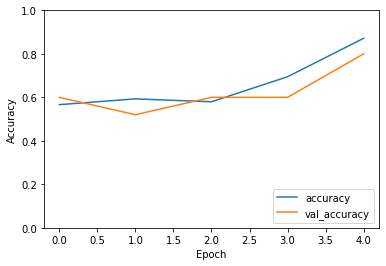

In [168]:
# predict test data and print accuracy
predicted_classes = argmax(model.predict(test_data), axis = 1)
accuracy = accuracy_score(predicted_classes, test_data.classes)
print(f"Test Accuracy: {accuracy}")

# print true and predicted class
to_print = []
for true, predicted in zip(test_data.classes, predicted_classes):
    to_print.append([classes[true], classes[predicted]])

print(tabulate(to_print, headers = ['True Class', 'Predicted Class']))

# plot accuracy against epochs
plt.plot(history.history['accuracy'], label= 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend(loc='lower right')
